In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import fastcluster
import statsmodels.stats.multitest as smm
from matplotlib.patches import Patch
import matplotlib
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.colors as colors
from matplotlib.colorbar import ColorbarBase

import statsmodels.formula.api as sm
import math

print(np.__version__)

1.25.2


In [2]:
data = pd.read_csv('<Path to the file containting all brain HPA genesets>', sep='\t')
data = data[data['0'].str.startswith('Brain')]
data.reset_index(inplace=True)
data.drop(columns={'index'}, inplace=True)
print(data.head())

                                       0  \
0                Brain/amygdala/amygdala   
1          Brain/amygdala/basal amygdala   
2        Brain/amygdala/central amygdala   
3  Brain/amygdala/corticomedial amygdala   
4        Brain/amygdala/lateral amygdala   

                                                   1  
0  ENSG00000001460;ENSG00000005108;ENSG0000000544...  
1  ENSG00000005421;ENSG00000005471;ENSG0000000548...  
2  ENSG00000005108;ENSG00000005381;ENSG0000000611...  
3  ENSG00000002726;ENSG00000004846;ENSG0000000518...  
4  ENSG00000005421;ENSG00000005471;ENSG0000000611...  


In [3]:
# Compute the Jaccard index between all pairs of genesets
matrix = np.zeros((data.shape[0], data.shape[0]))
for i, row in data.iterrows():
    genes_ref = row[1].split(';')
    for j, col in data.iterrows():
        genes_col = col[1].split(';')
        matrix[i,j]  =  len(list(set(genes_ref) & set(genes_col)))/len(list(set(genes_ref).union(genes_col)))

/tmp/ipykernel_425419/2948036870.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes_ref = row[1].split(';')
/tmp/ipykernel_425419/2948036870.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes_col = col[1].split(';')


In [4]:
df_mat_u = pd.DataFrame(matrix)
df_mat_u.columns = data['0'].tolist()
df_mat_u.index = data['0'].tolist()

In [8]:
effects = pd.read_csv('<Path the file with the effect sizes on cognition for the genesets loaded before>', sep = '\t')

In [9]:
# Filter the effects dataframe to only include the genesets that fits the criteria
effects = effects[(effects.cat == 'g') &
                (effects.ancestry == 'All') &
                (effects.diagnosis == 'wo_ASD') & 
                (effects.model_type == '1_3') & 
                (effects.win == 1) & 
                (effects.gene_list_name.str.startswith('Brain'))]

# Compute the adjusted p-values (FDR correction)
new_data = pd.DataFrame()
for cnv_type in effects.TYPE.unique():
    for combo in set(zip(effects['model_type'], effects['win'],  effects['diagnosis'])):
        print(combo)
        tmp = effects[(effects.TYPE==cnv_type) & (effects.model_type==combo[0]) & (effects.win==combo[1]) & (effects.diagnosis==combo[2])].copy()
        tmp['pvalue_adj'] = smm.fdrcorrection(tmp['pvalue'])[1]
        new_data = pd.concat([new_data, tmp])

# Merge the effect sizes for del and dups and the adjusted p-values into a single dataframe
es_data = new_data.pivot(columns='TYPE', values='Estimate', index='gene_list_name')
pvalue_data = new_data.pivot(columns='TYPE', values='pvalue_adj', index='gene_list_name')
both = pd.merge(es_data, pvalue_data, on='gene_list_name')
es_data['one_sig'] = np.where((both.DEL_y < 0.05) | (both.DUP_y < 0.05), True, False)
both.reset_index(inplace=True)
es_data.reset_index(inplace=True)
print(new_data.head())

('1_3', 1, 'wo_ASD')
('1_3', 1, 'wo_ASD')
                variable  Estimate        SE   tvalues    pvalue cat  win  \
8    DEL_LOEUF_gene_list  0.097578  0.042864  2.276457  0.022820   g    1   
38   DEL_LOEUF_gene_list  0.014416  0.024069  0.598936  0.549216   g    1   
68   DEL_LOEUF_gene_list  0.040619  0.034770  1.168218  0.242720   g    1   
98   DEL_LOEUF_gene_list  0.043421  0.022837  1.901346  0.057258   g    1   
128  DEL_LOEUF_gene_list -0.005864  0.026860 -0.218319  0.827181   g    1   

               aic            bic model_type  ... total_carriers  \
8    663414.945130  663570.656608        1_3  ...            498   
38   663422.863996  663578.575474        1_3  ...           1046   
68   663421.850000  663577.561478        1_3  ...            678   
98   663413.555450  663569.266927        1_3  ...           1368   
128  663425.444835  663581.156313        1_3  ...           1050   

                                          unique_genes  n_unique_genes  \
8    ENSG000

In [10]:
def compute_tagDS(es_data, data_CNV, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row.DEL + b*row.DUP + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row.DEL - row.DUP
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    es_data['tagDS'] = tagDS_vals 
    random_distri_tagDS = pd.read_csv('../permutations/Random_tagDS_distribution_mu_sd.tsv', sep='\t')
    tmp_data = pd.merge(es_data, data_CNV[data_CNV.TYPE=='DEL'].loc[:,['gene_list_name', 'gene_list_n']], on='gene_list_name', how='inner')
    print(tmp_data.gene_list_n.describe())
    tmp = pd.merge(tmp_data, random_distri_tagDS[['size', 'mu_s', 'sd_s']], left_on='gene_list_n', right_on='size', how='left')
    print(tmp.shape)
    tmp['zTagDS'] = (tmp['tagDS'] - tmp['mu_s'])/tmp['sd_s']
    return tmp

In [11]:
matrix_e = np.zeros((es_data.shape[0], es_data.shape[0]))
matrix_e[:] = np.nan


ratio = 0.426609501927956

print(ratio)

a = ratio
b = -1
c = 0

print(es_data)
es_data = compute_tagDS(es_data, new_data, ratio, b, c)
es_data['clean_tagDS'] = np.where(es_data.one_sig, es_data.zTagDS, 0)
print(es_data.shape)
        
for i, row in es_data.iterrows():
    for j, col in es_data.iterrows():
        if row.one_sig and col.one_sig:
            matrix_e[i,j]  =  (row.clean_tagDS + col.clean_tagDS) / 2


0.426609501927956
TYPE                                     gene_list_name       DEL       DUP  \
0                               Brain/amygdala/amygdala  0.097578  0.020415   
1                         Brain/amygdala/basal amygdala  0.014416 -0.000667   
2                       Brain/amygdala/central amygdala  0.040619 -0.000238   
3                 Brain/amygdala/corticomedial amygdala  0.043421 -0.013176   
4                       Brain/amygdala/lateral amygdala -0.005864  0.008317   
..                                                  ...       ...       ...   
210   Brain/white matter/parahippocampal cortex (whi... -0.048856  0.027871   
211   Brain/white matter/parieto-temporal junction (... -0.029815  0.026505   
212   Brain/white matter/somatomor cortex, precentra...  0.007776 -0.024008   
213   Brain/white matter/somatosensory cortex, postc...  0.018507 -0.034082   
214            Brain/white matter/temporal white matter -0.026864  0.013793   

TYPE  one_sig  
0       False  
1

13
{'amygdala': '#1f77b4', 'basal ganglia': '#aec7e8', 'cerebellum': '#ff7f0e', 'cerebral cortex': '#ffbb78', 'choroid plexus': '#2ca02c', 'hippocampal formation': '#98df8a', 'hypothalamus': '#d62728', 'medulla oblongata': '#ff9896', 'midbrain': '#9467bd', 'pons': '#c5b0d5', 'spinal cord': '#8c564b', 'thalamus': '#c49c94', 'white matter': '#e377c2'}
N Del sig = 25
N Dup sig = 60


/tmp/ipykernel_425419/1071041676.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  loeuf_cmap = matplotlib.cm.get_cmap('RdYlGn')


Mann-Whitney U Statistic: 2778.0
P-Value: 2.3760831019959086e-14


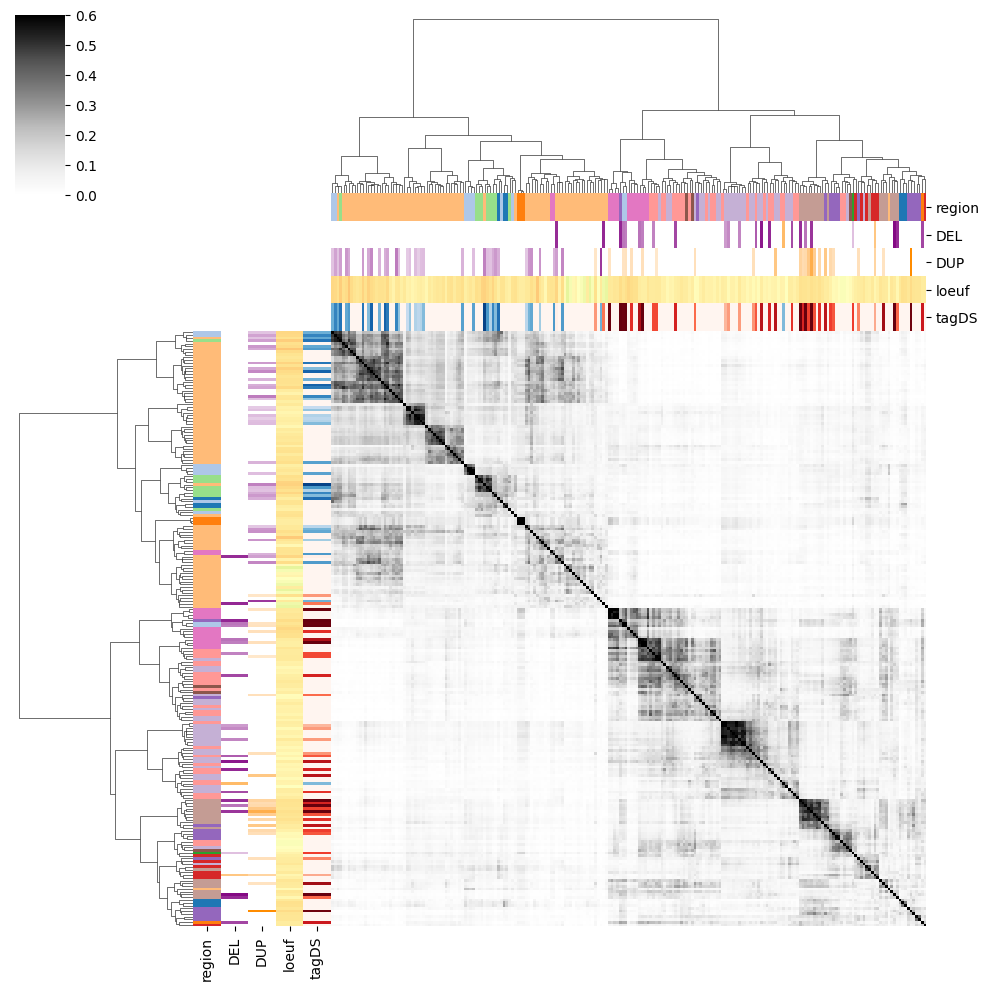

In [19]:
df_mat = pd.DataFrame(matrix_e)
df_mat.columns = es_data['gene_list_name'].tolist()
df_mat.index = es_data['gene_list_name'].tolist()


test = [x.split('/')[1] for x in df_mat_u.columns]
tmp = pd.DataFrame(test)
print(len(set(test)))

lut = dict(zip(list(dict.fromkeys(test)), sns.color_palette("tab20", len(set(test))).as_hex()))
print(lut)

loeuf_cmap = matplotlib.cm.get_cmap('RdYlGn')
loeufs = pd.read_csv('useful_data/loeuf_brain.tsv', sep='\t')
norm = plt.Normalize(0,2)

row_colors1 = loeuf_cmap(norm(loeufs.loeuf))
tmp_loeufs = [0.771, 0.913, 0.142, 0.906, 0.527, 1.169, 0.772]
row_colors1 = [matplotlib.colors.to_hex(c) for c in row_colors1]


bottom = LinearSegmentedColormap.from_list("mycmap", ['purple', "white"])
top = LinearSegmentedColormap.from_list("mycmap", [ "white", "darkorange"])

norm_top = plt.Normalize(0, new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max())
norm_bottom = plt.Normalize(-new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max(), 0)

both['b_del'] = [matplotlib.colors.to_hex(c) for c in bottom(norm_bottom(es_data.DEL))]
both['t_del'] = [matplotlib.colors.to_hex(c) for c in top(norm_top(es_data.DEL))]

both['val_del'] = np.where(both['DEL_y'] > 0.05, 'white', np.where(both['DEL_x']>=0, both['t_del'], both['b_del']))

both['b_dup'] = [matplotlib.colors.to_hex(c) for c in bottom(norm_bottom(es_data.DUP))]
both['t_dup'] = [matplotlib.colors.to_hex(c) for c in top(norm_top(es_data.DUP))]

both['val_dup'] = np.where(both['DUP_y'] > 0.05, 'white', np.where(both['DUP_x']>=0, both['t_dup'], both['b_dup']))

colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
all_colors = np.vstack((colors_dup, colors_del))
del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)
divnorm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
tagDS_col = [matplotlib.colors.to_hex(c) for c in del_dup_spe(divnorm(es_data.clean_tagDS))]

row_colors = pd.DataFrame({'region': pd.Series(tmp[0]).map(lut), 'DEL':both['val_del'], 'DUP':both['val_dup'], 'loeuf': row_colors1, 'tagDS':tagDS_col})
row_colors.index = df_mat.index

print('N Del sig = {}'.format(both[both['DEL_y'] <= 0.05].shape[0]))
print('N Dup sig = {}'.format(both[both['DUP_y'] <= 0.05].shape[0]))



clstred = fastcluster.ward(df_mat_u)
cluster_union = sns.clustermap(df_mat_u, col_colors=row_colors, row_colors=row_colors, cmap='Greys', yticklabels=False,xticklabels=False, row_linkage = clstred, col_linkage = clstred, vmax=0.6)


reordered_list = [df_mat_u.columns[i] for i in cluster_union.dendrogram_row.reordered_ind]

reordered_df = es_data.iloc[cluster_union.dendrogram_row.reordered_ind]
left_tag = reordered_df.head(101).clean_tagDS
right_tag = reordered_df.tail(reordered_df.shape[0]-101).clean_tagDS
statistic, p_value = scs.mannwhitneyu(left_tag, right_tag)

# Output the test statistic and p-value
print("Mann-Whitney U Statistic:", statistic)
print("P-Value:", p_value)



mask = np.tril(np.ones_like(df_mat_u))
values = cluster_union.ax_heatmap.collections[0].get_array().reshape(df_mat_u.shape)
new_values = np.ma.array(values, mask=mask)

ax = cluster_union.ax_heatmap

plt.show()

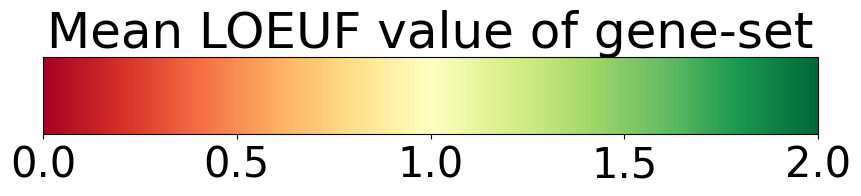

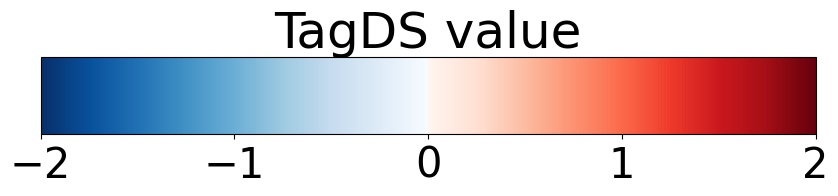

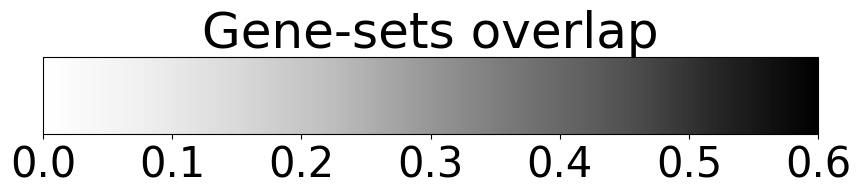

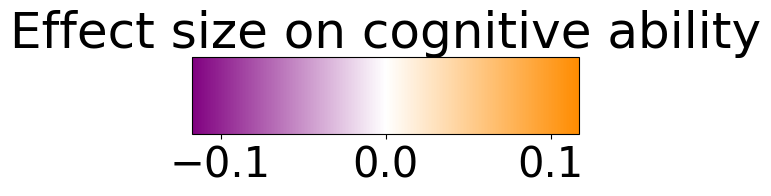

In [13]:
plt.rc('font', size=30)

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(10,1))
cbar = ColorbarBase(ax, cmap=loeuf_cmap, norm=plt.Normalize(vmin=0, vmax=2), orientation='horizontal')


# Show the plot
plt.title('Mean LOEUF value of gene-set')
plt.savefig('loeuf_cbar.svg', bbox_inches='tight')
plt.show()

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(10,1))
cbar = ColorbarBase(ax, cmap=del_dup_spe, norm=divnorm, orientation='horizontal')


# Show the plot
plt.title('TagDS value')
plt.savefig('effect_size_diff_cbar.svg', bbox_inches='tight')
plt.show()

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(10,1))
cbar = ColorbarBase(ax, cmap='Greys', norm=plt.Normalize(vmin=0, vmax=0.6), orientation='horizontal')


# Show the plot
plt.title('Gene-sets overlap')
plt.savefig('overlap_cbar.svg', bbox_inches='tight')
plt.show()


all_colors = np.vstack((bottom(np.linspace(0, 1, 256)),  top(np.linspace(0, 1, 256))))
del_dup_spe = LinearSegmentedColormap.from_list('del_dup_spe', all_colors)

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(5,1))
cbar = ColorbarBase(ax, cmap=del_dup_spe, norm=TwoSlopeNorm(vmin=-new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max(), vcenter=0, vmax=new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max()), orientation='horizontal')


# Show the plot
plt.title('Effect size on cognitive ability')
plt.savefig('effect_size.svg', bbox_inches='tight')

plt.show()